RNN - Erro dos pesos computados e usado somente durante a iteração

In [1]:
import numpy as np
from numpy import linalg as LA
import pandas as pd
import operator as op
import ipynbname
import math
import time
from Functions.Utils import *
from Functions.RLS import *
from Functions.RTLO import *
from Functions.Graphs import *

from Functions.TEDA import *
from Functions.TedaGraphs import *
import optuna
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_pareto_front
from optuna.importance import get_param_importances
from optuna.samplers import RandomSampler
import os
import re
import sys
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib as mpl
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random
import pickle
FileName = ipynbname.name()
K=0

def read_pkl(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    return data

In [2]:
path = r'Dataset\our_data\1-1.pkl'
df = pd.read_pickle(path)

In [3]:
df2 = df['1-1']['data'][1]
x,i,u,q = np.array([]),np.array([]),np.array([]),np.array([])
for k,sts in enumerate(df2['Status']):
    x = np.append(x,k)
    i = np.append(i,df2['Current (mA)'][k])
    u = np.append(u,df2['Voltage (V)'][k])
    q = np.append(q,df2['Capacity (mAh)'][k])
l = k


In [4]:
X,I,U,Q = [[] for w in range(4)]
l=0
for j in range(1,len(df['1-1']['data'])):
    df2 = df['1-1']['data'][j]
    x,i,u,q = np.array([]),np.array([]),np.array([]),np.array([])
    for k,sts in enumerate(df2['Status']):
        x = np.append(x,k)
        i = np.append(i,df2['Current (mA)'][k])
        u = np.append(u,df2['Voltage (V)'][k])
        q = np.append(q,df2['Capacity (mAh)'][k])
    X.append(x)
    I.append(i)
    U.append(u)
    Q.append(q)

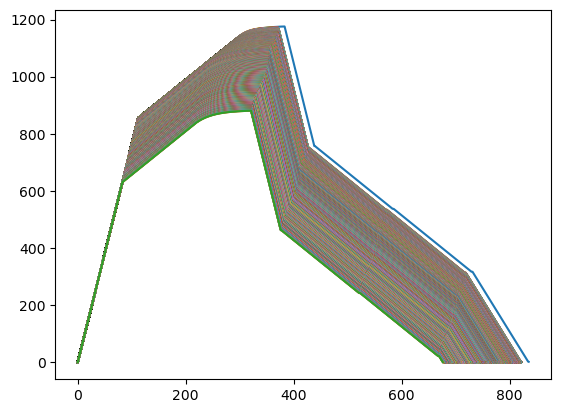

In [5]:
for x,q in zip(X,Q):
    plt.plot(x,q)

In [6]:
x= np.arange(10)
x

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [220]:
dir  = r'Dataset\Dataset_1_NCA_battery\Dataset_1_NCA_battery'
samples = os.listdir(dir)
samples.sort(key=lambda x: int(re.search(r'\d+', x).group()))
vec = []
for i,sample in enumerate(samples):
    if sample.startswith('CY25-025_1'):
        path = os.path.join(dir,sample)
        df1 = pd.read_csv(path)
        if i == 0:
            df = df1.copy()
        else:
            df = pd.concat([df,df1],axis=0)
print(df.columns)

Index(['time/s', 'control/V/mA', 'Ecell/V', '<I>/mA', 'Q discharge/mA.h',
       'Q charge/mA.h', 'control/V', 'control/mA', 'cycle number'],
      dtype='object')


In [295]:
df[:]

,time/s,control/V/mA,Ecell/V,<I>/mA,Q discharge/mA.h,Q charge/mA.h,control/V,control/mA,cycle number
0,0.000000,3500.0,3.149101,0.058311,0.000000,0.001944,0.0,3500.0,2.0
1,0.014000,3500.0,3.154381,3499.796569,0.000000,0.015554,0.0,3500.0,2.0
2,0.070000,3500.0,3.159463,3500.127389,0.000000,0.070001,0.0,3500.0,2.0
3,0.202000,3500.0,3.164467,3500.217622,0.000000,0.198342,0.0,3500.0,2.0
4,0.412000,3500.0,3.169628,3500.402831,0.000000,0.402532,0.0,3500.0,2.0
...,...,...,...,...,...,...,...,...,...
32895,464506.723856,0.0,3.358393,0.000000,2507.992692,0.000000,0.0,0.0,36.0
32896,464626.723869,0.0,3.363239,0.000000,2507.992692,0.000000,0.0,0.0,36.0
32897,464746.723881,0.0,3.367376,0.000000,2507.992692,0.000000,0.0,0.0,36.0
32898,464866.723894,0.0,3.371158,0.000000,2507.992692,0.000000,0.0,0.0,36.0


In [358]:
df2

,time/s,control/V/mA,Ecell/V,<I>/mA,Q discharge/mA.h,Q charge/mA.h,control/V,control/mA,cycle number
31898,451924.220544,3500.0,3.486521,0.058311,0.000000,0.001944,0.0,3500.0,36.0
31899,451924.286544,3500.0,3.491643,3499.939669,0.000000,0.066109,0.0,3500.0,36.0
31900,451924.450544,3500.0,3.496647,3500.296306,0.000000,0.225567,0.0,3500.0,36.0
31901,451924.692544,3500.0,3.501650,3500.263815,0.000000,0.460863,0.0,3500.0,36.0
31902,451924.992544,3500.0,3.506694,3500.316679,0.000000,0.752556,0.0,3500.0,36.0
...,...,...,...,...,...,...,...,...,...
32895,464506.723856,0.0,3.358393,0.000000,2507.992692,0.000000,0.0,0.0,36.0
32896,464626.723869,0.0,3.363239,0.000000,2507.992692,0.000000,0.0,0.0,36.0
32897,464746.723881,0.0,3.367376,0.000000,2507.992692,0.000000,0.0,0.0,36.0
32898,464866.723894,0.0,3.371158,0.000000,2507.992692,0.000000,0.0,0.0,36.0


In [363]:
df = pd.read_csv(r'Dataset\Dataset_1_NCA_battery\Dataset_1_NCA_battery\CY25-05_1-#1.csv')
#df = normalize_df(df)
IDs = list(set(list(df['cycle number'])))
Q,T = [],[]
for ID in IDs[:]:
    df2 = df[df['cycle number']==ID]
    df2 = df2[df2['control/mA']==-3500]
    #x = np.arange(len(df2))
    x = df2.iloc[:,0].values
    y1 = df2.iloc[:,2].values
    y2 = df2.iloc[:,7].values
    Q.append(y1)
    T.append(x-x[0])
    #plt.plot(x,y1)
    #plt.plot(x,y2)

C:\Users\claud\AppData\Local\Temp\ipykernel_3332\1954080235.py:3: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



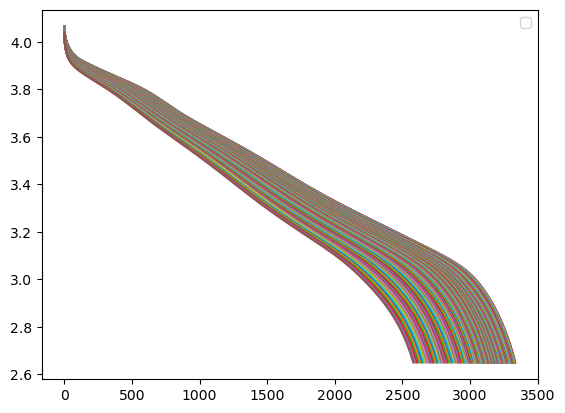

In [364]:
for t,q in zip(T,Q):
    plt.plot(t,q)
plt.legend()

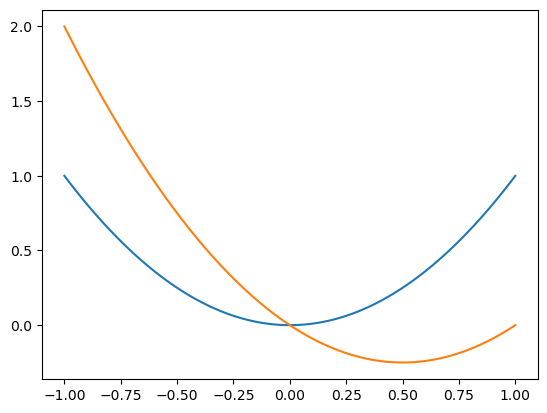

In [10]:
def f1(x):
    return x**2
def f2(x):
    return x**2-x

x=np.linspace(-1,1,100)
y1=f1(x)
y2=f2(x)
plt.plot(x,y1)
plt.plot(x,y2)

In [12]:
import numpy as np

# Define the function, its first derivative (gradient), and second derivative (Hessian)
def f(x):
    return x**2-x

def df(x):
    return 2*x-1

def ddf(x):
    return 2

# Newton's method implementation
def newtons_method(x0, tolerance=1e-6, max_iterations=100):
    x = x0
    for i in range(max_iterations):
        derivative = df(x)
        second_derivative = ddf(x)
        
        # Newton update formula
        if second_derivative == 0:
            print("Zero second derivative. Method fails.")
            break
            
        x_new = x - derivative / second_derivative
        
        # Check for convergence
        if abs(x_new - x) < tolerance:
            return x_new
        
        x = x_new
        
    return x

# Initial guess
x0 = 2
minimum = newtons_method(x0)
print(f"Minimum found at: {minimum}")
print(f"Function value at minimum: {f(minimum)}")


Minimum found at: 0.5
Function value at minimum: -0.25
